In [1]:
import pandas as pd

In [125]:
dati_test = pd.read_csv(r"C:\Users\giode\PycharmProjects\Script_Tesi_new\Dati\HouseTwenty\HouseTwenty_TEST.txt", delim_whitespace=True, header=None)

dati_train = pd.read_csv(r"C:\Users\giode\PycharmProjects\Script_Tesi_new\Dati\HouseTwenty\HouseTwenty_TRAIN.txt", delim_whitespace=True, header=None)

dati_train = dati_train.drop(0, axis= 1)
dati_test = dati_test.drop(0, axis= 1)

dati_train = dati_train.stack().reset_index()
dati_test = dati_test.stack().reset_index()

In [126]:
dati_train

,level_0,level_1,0
0,0,1,349.0
1,0,2,349.0
2,0,3,347.0
3,0,4,351.0
4,0,5,347.0
...,...,...,...
79995,39,1996,3814.0
79996,39,1997,3917.0
79997,39,1998,3790.0
79998,39,1999,3846.0


In [128]:
dati_train = dati_train.rename(columns = {'level_0':'Count_days','level_1':'Tick',0:'PowerConsumption'})
dati_train = dati_train[['Count_days','Tick','PowerConsumption']]

dati_test = dati_test.rename(columns = {'level_0':'Count_days','level_1':'Tick',0:'PowerConsumption'})
dati_test = dati_test[['Count_days','Tick','PowerConsumption']]

In [130]:
dati_test.PowerConsumption.isna().sum()

0

<AxesSubplot:>

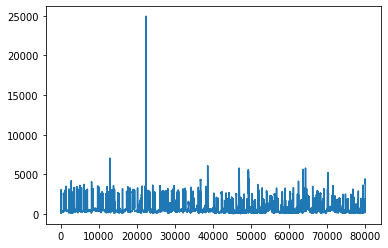

In [136]:

dati_train.PowerConsumption.plot()

In [132]:
dati_test.PowerConsumption.isna().sum()

0

<AxesSubplot:>

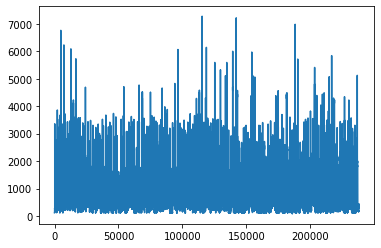

In [133]:
dati_test.PowerConsumption.plot()